In [1]:
from sklearn.svm import SVR
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import make_pipeline
import pandas as pd
import os

def get_direct_analysis_data(
    directory: str,
) -> pd.DataFrame:
    df_all = pd.DataFrame()

    files = os.listdir(directory)

    for file_name in files:
        df = pd.read_csv(f"{directory}/{file_name}")
        df.fillna(0, inplace=True)
        df.drop(["Unnamed: 0", "selection_ids", "market_id"], axis=1, inplace=True)
        df = df[df["mean_14400"] < 30]
        df = df[df["mean_14400"] > 0.5]
        df_all = pd.concat([df_all, df], ignore_index=True)

    return df_all

df = get_direct_analysis_data("data")
df.head(5)

,bsps,mean_120,std_120,volume_120,RWoML_120,RWoMB_120,mean_130,std_130,volume_130,RWoML_130,...,mean_7200,std_7200,volume_7200,RWoML_7200,RWoMB_7200,mean_14400,std_14400,volume_14400,RWoML_14400,RWoMB_14400
0,4.300000,4.016140,0.057279,904.14,392.508,270.822,4.000000,0.000000,399.77,350.533,...,3.874707,0.256945,1886.69,36.436072,24.197850,3.736581,0.143388,938.95,36.969281,19.905317
1,6.012691,5.851122,0.050032,559.19,142.940,138.994,5.804075,0.140305,1080.61,220.761,...,5.738189,0.253578,691.24,20.678674,21.705308,5.272967,0.304783,262.42,12.255378,11.795204
2,3.949456,3.723241,0.036249,1373.55,279.428,415.215,3.771105,0.024714,648.76,727.346,...,3.513197,0.234067,3664.21,31.638283,22.463525,4.295124,0.408862,2216.17,29.000911,32.684897
3,9.205764,10.000000,0.000000,231.91,320.551,158.483,10.048542,0.148137,732.46,311.743,...,11.756249,1.348857,282.46,76.482327,14.314667,12.642264,0.434633,214.32,6.735112,12.781230
4,12.411758,15.925687,0.178206,257.29,126.989,176.787,16.135873,0.224004,71.39,141.968,...,14.066831,1.326065,404.68,10.829505,18.538931,10.023866,1.569440,483.20,13.693668,9.158632


In [2]:
from sklearn.neural_network import MLPClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.gaussian_process import GaussianProcessClassifier
from sklearn.gaussian_process.kernels import RBF
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis
import numpy as np
from sklearn.linear_model import LinearRegression, Ridge, LogisticRegression, BayesianRidge, SGDRegressor
from sklearn.metrics import mean_squared_error as mse, mean_absolute_error as mae, r2_score

def rms(y,y_pred):
    rms=np.sqrt(np.mean((y-y_pred)**2))
    return rms
    
models = {
    "regressor": {
        "SVR": SVR(C=1.0, epsilon=0.2),
        "Ridge": Ridge(),
        "BayesianRidge": BayesianRidge(),
        "LinearRegression": LinearRegression(),
    }
}

def get_models_predictions(models, X_train, y_train, X_test):
    predictions = {}

    for m_type_name, m_type in models.items():

        for c_name, c in m_type.items():

            # Regression
            if m_type_name == "regressor":
                regr = make_pipeline(StandardScaler(), c)
                regr.fit(X_train, y_train)

                y_pred = regr.predict(X_test)

                predictions[c_name] = y_pred


            # classification
    return predictions

y = df["bsps"]
X = df.drop("bsps", axis=1)

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.33, random_state=42
)
predictions = get_models_predictions(models, X_train, y_train, X_test)
print(predictions)

{'SVR': array([27.05133225, 10.32280493, 13.23055255, ..., 14.33595031,
       19.01225313, 21.31916711]), 'Ridge': array([23.82894338, 13.37573624,  6.06163161, ..., 13.46537887,
       23.52038733, 20.29159411]), 'BayesianRidge': array([24.23001988, 13.25684136,  8.60520997, ..., 13.7996054 ,
       24.28364272, 20.65986788]), 'LinearRegression': array([23.8283772 , 13.37620013,  5.9968329 , ..., 13.46443134,
       23.50629962, 20.28304621])}


In [3]:
pd.options.display.float_format = '{:20,.2f}'.format


def get_prediction_metrics(predictions, y_test, X_test):
    metrics_df = pd.DataFrame()
    
    y_test.reset_index(drop=True, inplace=True)
    for model_name, y_pred in predictions.items():

        r2 = r2_score(y_test, y_pred)
        n = len(y_test)
        k = len(X_test.columns)
        adj_r2_score = 1-(((1-r2)*(n-1))/(n-k-1))

        new_row = pd.DataFrame(
            [
                {
                    "model": model_name,
                    "mse": mse(y_test, y_pred),
                    "mae": mae(y_test, y_pred),
                    "rms": rms(y_test, y_pred),
                    "rmse": mse(y_test, y_pred, squared=False),
                    "r2_score": r2,  
                    "adjusted_r2_score": adj_r2_score
                }
            ]
        )
        metrics_df = pd.concat([metrics_df, new_row])

    metrics_df.set_index("model", inplace=True)
    return metrics_df
    
metrics_df = get_prediction_metrics(predictions, y_test, X_test)
metrics_df.head(20)

,mse,mae,rms,rmse,r2_score,adjusted_r2_score
model,,,,,,
SVR,112.72,3.24,10.62,10.62,0.44,0.42
Ridge,79.59,3.30,8.92,8.92,0.60,0.59
BayesianRidge,78.44,3.21,8.86,8.86,0.61,0.60
LinearRegression,79.60,3.30,8.92,8.92,0.60,0.59


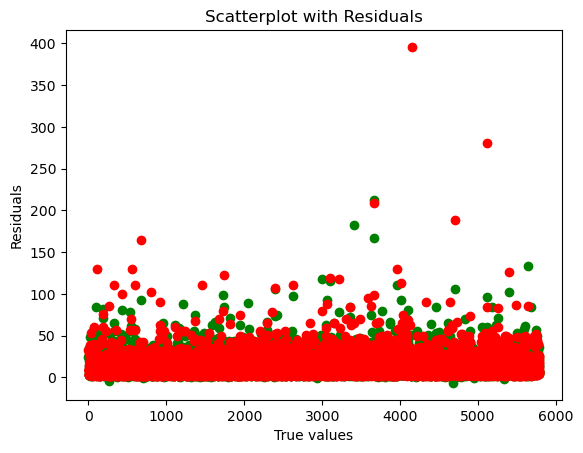

In [5]:
import matplotlib.pyplot as plt

# calculate residuals
y_pred = predictions['BayesianRidge']
residuals = y_test - y_pred

k = [x for x in range(len(y_test))]
# create a scatterplot with residuals
plt.scatter(k, y_pred, color="green", label="pred")
plt.scatter(k, y_test, color="red", label="actual")
plt.xlabel("True values")
plt.ylabel("Residuals")
plt.title("Scatterplot with Residuals")
plt.show()

In [17]:
from numpy import sort


ms = [mse([y_test[i]], [y_pred[i]]) for i in range(len(y_test))]
ms = sort(ms)
for k in reversed(ms):
    print(k)    

142793.9988006209
34156.54789689415
13664.241329141565
12909.215791641052
12816.736201467065
7980.376020049066
6740.625116556747
5644.906380828194
5318.608573952819
5118.607278686899
4577.3088729154715
4102.374983176966
3649.6381409312266
3074.4822182521307
3018.6640238883792
2958.0993475874902
2895.694582744731
2691.5702500934435
2628.6915142136054
2248.3598238094837
2239.9186747657745
2020.3728635161024
1983.315200567174
1960.4224465772265
1903.798174744236
1746.448640543598
1695.3778284773416
1632.9118640199065
1600.4135665679676
1592.7895192667097
1576.5532402815631
1574.366592816331
1492.1285776293992
1489.1990417309162
1477.4305900590875
1456.5303146493725
1440.3354170545128
1409.8077129624278
1408.9037891719859
1404.2654849864987
1194.8313518311118
1159.7903502395957
1155.481817401894
1099.5816509869555
1075.34247520584
1074.9057829439557
1058.5945777303796
1052.9386240861127
1050.9188741412459
1038.240410080006
980.3403953298974
979.1388357212965
910.8158712594827
875.045846420

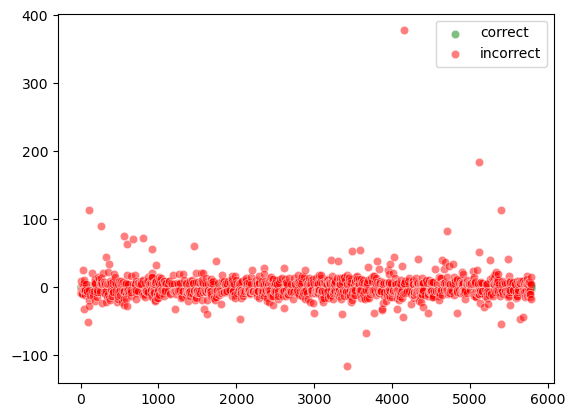

accuracy = 0.778852798894264


In [28]:
import seaborn as sns

# define a threshold for "correct" predictions
threshold = 15
# classify the predictions as "correct" or "incorrect" based on MSE
correct = [i for i in range(len(y_test)) if mse([y_test[i]], [y_pred[i]]) < threshold]
incorrect = [i for i in range(len(y_test)) if mse([y_test[i]], [y_pred[i]]) >= threshold]

# create a scatterplot with residuals
sns.scatterplot(x=[i for i in correct], y=[y_test[i] - y_pred[i] for i in correct], color="green", label="correct", alpha=.5)
sns.scatterplot(x=[i for i in incorrect], y=[y_test[i] - y_pred[i] for i in incorrect], color="red", label="incorrect", alpha=.5)

plt.legend()
plt.show()

# calculate the accuracy of the predictions
accuracy = len(correct) / len(y_test)
print("accuracy =", accuracy)

In [13]:
from sklearn.preprocessing import PolynomialFeatures

# transform data to include polynomial terms to third degree
poly = PolynomialFeatures(degree = 2)
X_degree3 = poly.fit_transform(X)

X_degree3.shape

(17537, 18336)

In [ ]:
X3_train, X3_test, y3_train, y3_test = train_test_split(
    X_degree3, y, test_size=0.33, random_state=42
)

predictions = get_models_predictions(models, X3_train, y3_train, X3_test)
metrics_df = get_prediction_metrics(predictions, y3_test, X3_test)
metrics_df.head(20)